# Adaline with Pytorch

In [318]:
import torch
import torch.nn as nn
import numpy as np
import math
from sklearn.metrics import mean_squared_error as mse
from torch.autograd import grad
import torch.nn.functional as fun
import matplotlib.pyplot as plt

In [319]:
class Adaline(nn.Module):
    def __init__(self, nX, nY):        
        super(Adaline, self).__init__() # конструктор предка с этим именем
        self.fc1 = nn.Linear(nX, nY)
        self.fc1.weight.detach()
        self.fc1.bias.detach()# создаём параметры модели
        
    def forward(self, x): # задаётся прямой проход
        x = self.fc1(x)
        return x


In [320]:
def train(model, x, y, num_epochs, learning_rate=0.001, stop_criterion=10**(-6),random_state=3):               
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    score_list=[]
    
    torch.manual_seed(random_state)

    for e in range(num_epochs):
        shuffle_idx = torch.randperm(x.size()[0], dtype=torch.long) #задаем параметр перемешивания 
        x_i = x[shuffle_idx]
        y_i = y
        y_pred = model.forward(x_i)
        loss = fun.mse_loss(y_pred, y_i)
        optimizer.zero_grad()
            
        loss.backward()
        optimizer.step()
        
        score_list.append(loss.detach().numpy())
        if loss<=stop_criterion:#критерий остановки обучения
            break
    print(fun.mse_loss(y_pred, y_i))
    return y_pred


# One-step Adaptive Linear Combiner

* Использовать линейную нейронную сеть с задержками для аппроксимации функции для одношагового прогноза. 
* В качестве метода обучения использовать адаптацию. 

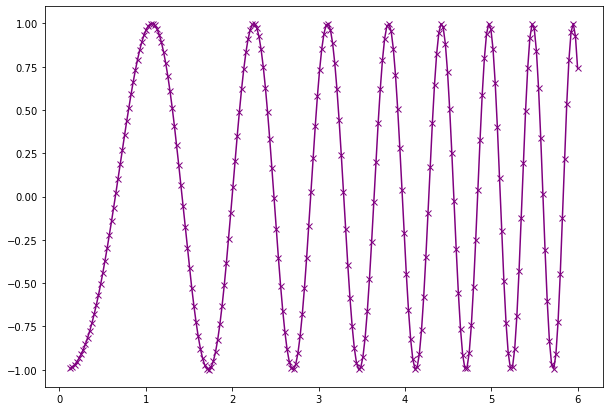

In [280]:
step1=0.025
d1=5
t1=np.linspace(0,6,int(6/step1))

def func_1(x):
    return (math.cos(x**2 + 2*x +3))

# def preparing_tensor(input_tensor): #(1x5)
#     output_tensor=torch.empty(size=(input_tensor.size()[0],1)) #(5x1)
#     for index in range(input_tensor.size()[0]):
#         output_tensor[index]=input_tensor[index]
#     return output_tensor

def preparing_data(t,d,func):
    X_train = np.vectorize(func)(t[0:d])
    X_test = np.vectorize(func)(t[d:])
    y_train=np.array([X_test[0]])
    return X_train,X_test,y_train

X_train,X_test,y_train = preparing_data(t1,d1,func_1)

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(t1[d1:],X_test,marker='x',color='purple')
plt.show()

In [281]:
model = Adaline(d1, 1)

X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()
X_test=torch.from_numpy(X_test).float()

tensor(7.8090e-05, grad_fn=<MseLossBackward0>)


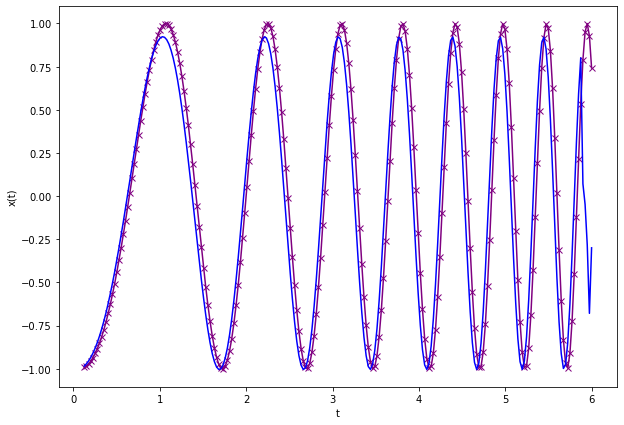

In [282]:
fit_param = train(model, #обучаем модель на тренировочной выборке
             X_train, y_train,
             num_epochs=200,
             learning_rate=0.1,
             random_state=1)

def plot_result_1(t,d,X_test):
    aproximate=torch.empty(len(t[d:])+1)

    for i in range(len(t[d:])-5):
        train_pred = model.forward(X_test[i:i+d].float())
        aproximate[i]=train_pred
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    ax.plot(t[d:],X_test,marker='x',color='purple')
    ax.plot(t[d:],aproximate[:-1].detach().numpy(),color='blue')
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.show()
    
plot_result_1(t1,d1,X_test)
    

In [235]:
print(*model.parameters())
model#отразить модель в отчете

Parameter containing:
tensor([[-0.0953,  0.2646,  0.2946,  0.2926,  0.2801]], requires_grad=True) Parameter containing:
tensor([-0.3460], requires_grad=True)


Adaline(
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

## More steps Adaptive Linear Combiner

* Использовать линейную нейронную сеть с задержками для аппроксимации функции для многошагового прогноза.
* В качестве метода обучения использовать адаптацию.

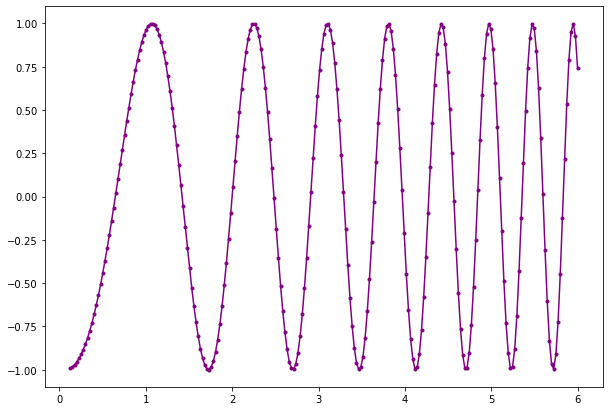

In [236]:
step=0.025
d2=5
t2=np.linspace(0,6.5,int(6.5/step))
k=10

X_train,X_test,y_train = preparing_data(t1,d2,func_1)


X_train = np.vectorize(func_1)(t1[0:d2])
X_test = np.vectorize(func_1)(t1[d2:])
y_train=np.array([X_test[1]])


fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(t1[d2:], X_test,marker='.',color='purple')

plt.show()

In [237]:
model = Adaline(d2, 1)

X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()
X_test=torch.from_numpy(X_test).float()

tensor(0.0120, grad_fn=<MseLossBackward0>)


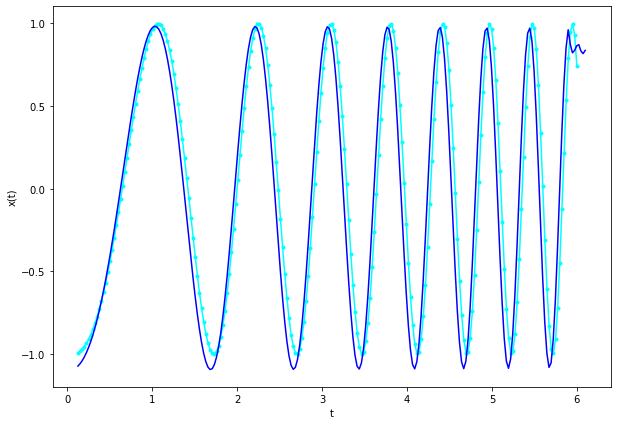

In [238]:
fit_param = train(model, #обучаем модель на тренировочной выборке
             X_train, y_train,
             num_epochs=600,
             learning_rate=0.001,
             random_state=1)

#print(X_test)

def plot_result_2(t1,t2,d,X_test):
    aproximate=torch.empty(len(t1[d:])+k-d)

    for i in range(len(t1[d:])+k-d):
        if i>=(len(t1[d:])-d):
            X_test=torch.hstack((X_test,aproximate[i-1]))
        train_pred = model.forward(X_test[i:i+d].float())
        aproximate[i]=train_pred        

    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    ax.plot(t1[d:],X_test[:len(X_test)-10].detach().numpy(),marker='.',color='cyan')
    ax.plot(t2[d:len(aproximate)+d2-1],aproximate[:-1].detach().numpy(),color='blue')
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.show()

    
plot_result_2(t1,t2,d2,X_test)

In [157]:
print(*model.parameters())

Parameter containing:
tensor([[-0.1825,  0.4094, -0.0416, -0.1374,  0.5720]], requires_grad=True) Parameter containing:
tensor([-0.3618], requires_grad=True)


# Adaptive Linear Filter with Pseudoinverse matrix

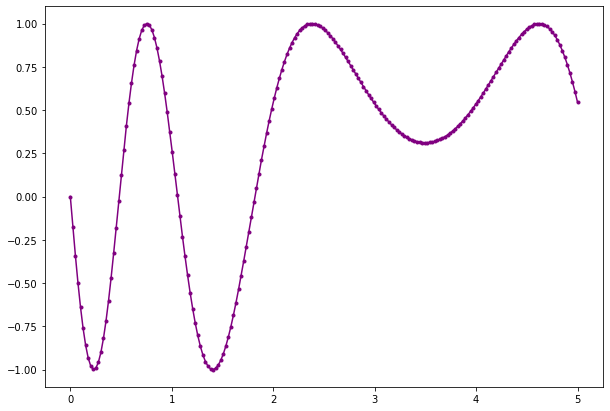

In [12]:
step=0.025
t3=np.linspace(0,5,int(5/step))
d3=4

def func_2(x):
    return (math.sin(x**2 - 7*x))

def func_3(x):
    return (0.5*math.sin(x**2 - 7*x +math.pi/4))


P = np.vectorize(func_2)(t3)
y_test=np.vectorize(func_3)(t3)

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(t3, P, marker='.',color='purple')

plt.show()

In [13]:
model = Adaline(d3, 1)
P=torch.from_numpy(P).float()
X_test=torch.empty(P.size()[0])

p_list=[]
for i in range(d3):
    p_list.append(torch.hstack((torch.zeros(d3-i),P[:-d3+i]))) 

X_train=torch.empty(4, len(p_list[0]))

for i in range(4):
    X_train[i] = p_list[i]
#print(X_train.shape)    
y_train=P.view(1,200)


torch.Size([4, 200])
torch.Size([200, 4])
torch.Size([1, 200])
tensor([[ 0.1487, -0.1279, -1.1543,  2.1281]])
tensor([[ 0.1487, -0.1279, -1.1543,  2.1281]])
torch.Size([1, 200])


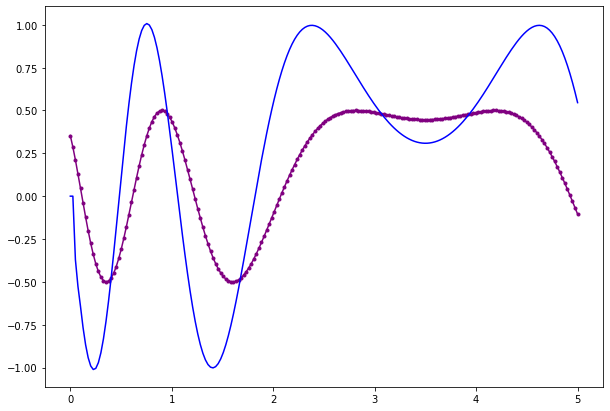

In [14]:
# fit_param = train(model, #обучаем модель на тренировочной выборке
#              X_train, y_train,
#              num_epochs=600,
#              learning_rate=0.01,
#              random_state=1)

#train_pred = model.forward(X_train)
X_pseudoinverse=torch.linalg.pinv(X_train)
print(X_train.shape)
print(X_pseudoinverse.shape)
print(y_train.shape)
Weights=torch.matmul(y_train,X_pseudoinverse)
print(Weights)

X_train_new = X_train.view(4,200)
new_weights = Weights.view(1,4)

print(new_weights)
y_pred=torch.matmul(new_weights, X_train_new)
 
print(y_pred.shape)
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(t3, y_test,marker='.',color='purple')
ax.plot(t3,y_pred.detach().numpy().reshape(200),color='blue')
plt.show()
# # print(*model.parameters())